In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path,ElasticNet
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import scale, Imputer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# read data
df = pd.read_csv("dummt_transformed.csv")
df = df.iloc[:,1:]

In [3]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# check missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

,Total,Percent
LotFrontage,259,0.177397


In [5]:
variables = df.columns.tolist()
y_index = df.columns.tolist().index('SalePrice')
#NA_index = df.columns.tolist().index('LotFrontage')
y = np.log(df.iloc[:,y_index])
variables.pop(y_index)
#variables.pop(NA_index)
X = df.loc[:,variables]

imp = Imputer(missing_values = 'NaN', strategy = "mean", axis = 0)
imp = imp.fit(X)
X = imp.transform(X)

In [6]:
X_df = df.loc[:,variables]

### Linear Regression

In [40]:
model = LinearRegression()
score = np.mean(-cross_val_score(model, X, y,scoring="neg_mean_squared_error", cv = y.shape[0]))
print "linear regression score: ", score

linear regression score:  0.0396942171813


### Ridge Regression

In [26]:
alphas = np.logspace(-6,4,11)
alphas

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03,   1.00000000e+04])

In [27]:
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [28]:
zip(alphas,LOOr)

[(9.9999999999999995e-07, 0.039693601249437112),
 (1.0000000000000001e-05, 0.039688037106184987),
 (0.0001, 0.039630429011628006),
 (0.001, 0.038952131058391889),
 (0.01, 0.033813169666875989),
 (0.10000000000000001, 0.025595562272544076),
 (1.0, 0.022247875076717358),
 (10.0, 0.021038992601428608),
 (100.0, 0.022146950099809964),
 (1000.0, 0.026786949177101713),
 (10000.0, 0.034330194462211569)]

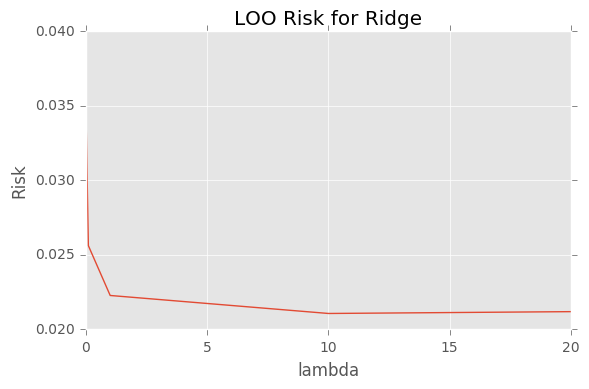

In [32]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.tight_layout()
plt.savefig("Ridge_alpha_loo.png")
plt.show()


In [30]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(10.0, 0.021038992601428608)

In [31]:
print "LOO square error risk for ridge under the best lambda is {:.7f}".format(
    min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])[1])

LOO square error risk for ridge under the best lambda is 0.0210390


### Lasso Path and Lars Path

In [14]:
lasso_path = lars_path(np.array(X),np.array(y),method="lasso")
#lars_path = lars_path(np.array(X),np.array(y),method="lar")

/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 253 iterations, i.e. alpha=8.869e-05, with an active set of 195 regressors, and the smallest cholesky pivot element being 8.429e-08
  ConvergenceWarning)
/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 296 iterations, alpha=1.454e+01, previous alpha=4.434e-05, with an active set of 223 regressors.
  ConvergenceWarning)


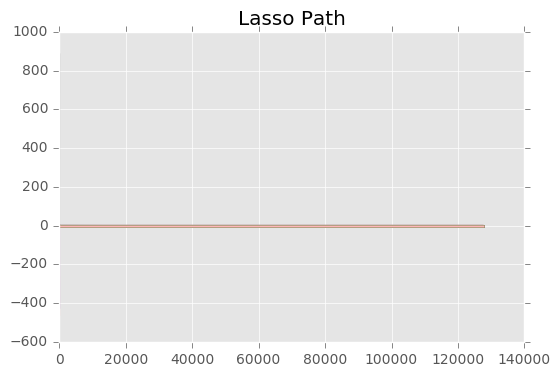

In [15]:
for j in xrange(X.shape[1]):
    _ = plt.plot(lasso_path[0],lasso_path[2][j,:])
#_ = plt.xlim([0,6])
#_ = plt.xlim(plt.xlim()[::-1])
#_ = ax[0].set_ylim([-500,500])
_ = plt.title("Lasso Path")

### Lasso

In [16]:
loo = LeaveOneOut()
looiter = loo.split(X)
lasso_model = LassoCV(cv=looiter)
lasso_model.fit(X,y)
print("The selected lambda value is {:.2f}".format(lasso_model.alpha_))

The selected lambda value is 1.03


In [17]:
np.mean(lasso_model.mse_path_[lasso_model.alphas_ == lasso_model.alpha_])

0.039885723197330143

### Fitting Ridge Regression using the variables selected by Lasso

In [33]:
variable_chosen = X_df.iloc[:,lasso_model.coef_ != 0]
variable_chosen.columns

Index([u'LotArea', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'TotalBsmtSF', u'2ndFlrSF', u'GrLivArea', u'GarageYrBlt',
       u'GarageArea', u'WoodDeckSF', u'ScreenPorch', u'MiscVal'],
      dtype='object')

In [34]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(variable_chosen,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [35]:
dict(zip(alphas,LOOr))

{9.9999999999999995e-07: 0.036139863571387598,
 1.0000000000000001e-05: 0.036139863571392421,
 0.0001: 0.036139863571441548,
 0.001: 0.036139863571932544,
 0.01: 0.036139863576842124,
 0.10000000000000001: 0.0361398636259379,
 1.0: 0.036139864116914021,
 10.0: 0.036139869028501859,
 100.0: 0.03613991832697494,
 1000.0: 0.036140429504468316,
 10000.0: 0.036147296266618362}

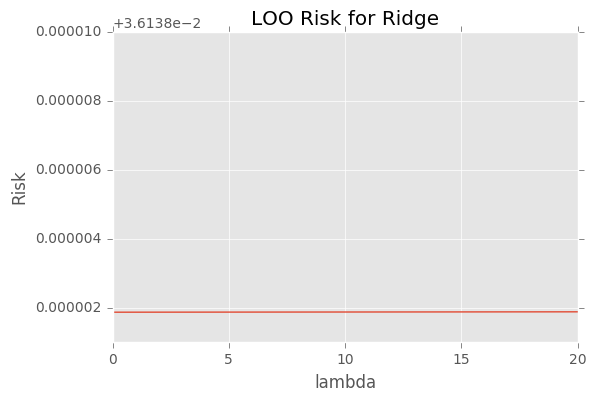

In [36]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.show()

In [37]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(9.9999999999999995e-07, 0.036139863571387598)

In [41]:
# Linear model after feature selecte by Lasso
model = LinearRegression()
score = np.mean(-cross_val_score(model, variable_chosen,y,scoring="neg_mean_squared_error", cv = y.shape[0]))
print "linear regression score: ", score

linear regression score:  0.0361398635714


In [44]:
# The mse here is smaller than Lasso

### Elastic Net

In [58]:
parameters = {"l1_ratio" : [0.1,0.25,0.5,0.75],"alpha" : alphas}
ela_model = GridSearchCV(ElasticNet(),parameters, cv = 5)
ela_model.fit(X,y)
ela_model.best_estimator_ 

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
ela_model.best_score_

0.86982546090709034

In [60]:
parameters = {"l1_ratio" : [0.1,0.25,0.5,0.75],"alpha" : alphas}
ela_model = GridSearchCV(ElasticNet(),parameters, cv = 5)
ela_model.fit(variable_chosen,y)
ela_model.best_estimator_

ElasticNet(alpha=9.9999999999999995e-07, copy_X=True, fit_intercept=True,
      l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [61]:
ela_model.best_score_

0.7725064155602781

### Decision Tree Regressor

In [62]:
from sklearn.tree import DecisionTreeRegressor

In [100]:
for i in [10,20,50,100,200,500]:
    regressor = DecisionTreeRegressor(random_state=0, max_depth = i)
    print "when n is {}, CV score is {}".format(
        i,np.mean(-cross_val_score(regressor, X, y, cv=10,scoring='neg_mean_squared_error')))

when n is 10, CV score is 0.0398607243407
when n is 20, CV score is 0.0416753571474
when n is 50, CV score is 0.0412911083851
when n is 100, CV score is 0.0412911083851
when n is 200, CV score is 0.0412911083851
when n is 500, CV score is 0.0412911083851


In [92]:
DTregressor = DecisionTreeRegressor(random_state=0, max_depth = 10)
DTregressor.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [72]:
#DTregressor.feature_importances_

In [93]:
X_df.columns[DTregressor.feature_importances_ != 0]

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtUnfSF',
       ...
       u'PavedDrive_Y', u'Fence_MnPrv', u'Fence_No', u'MiscFeature_Shed',
       u'SaleType_ConLD', u'SaleType_New', u'SaleType_WD',
       u'SaleCondition_Family', u'SaleCondition_Normal',
       u'SaleCondition_Partial'],
      dtype='object', length=122)

In [94]:
feature_importance = dict(zip(X_df.columns,DTregressor.feature_importances_))

In [95]:
import operator
rank_importance = pd.DataFrame(sorted(feature_importance.iteritems(), key=operator.itemgetter(1), reverse=True)[:20])

In [96]:
rank_importance= rank_importance.rename(columns = {0:"Variables",1:"Feature Importance"})
rank_importance.head()

,Variables,Feature Importance
0,OverallQual,0.574844
1,GrLivArea,0.131583
2,TotalBsmtSF,0.070889
3,CentralAir_Y,0.018262
4,OverallCond,0.017615


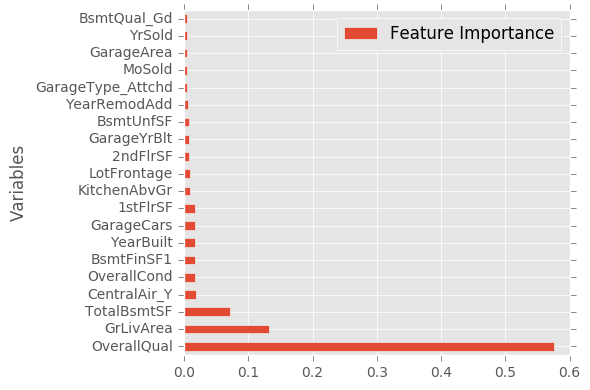

In [97]:
rank_importance.plot.barh(x = "Variables")
plt.tight_layout()
plt.savefig("Feature_importance_DT.png")

In [85]:
rank_importance.sort_values(by = "Feature Importance", ascending = False).head(10).iloc[:,0].tolist()

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'YearBuilt',
 'BsmtFinSF1',
 'CentralAir_Y',
 'OverallCond',
 'GarageCars',
 '1stFlrSF',
 'KitchenAbvGr']

In [101]:
variable_select_DT = rank_importance.sort_values(by = "Feature Importance", ascending = False).head(35).iloc[:,0].tolist()
X_DT = pd.DataFrame(X_df.loc[:,variable_select_DT])
X_DT.head()

,OverallQual,GrLivArea,TotalBsmtSF,CentralAir_Y,OverallCond,BsmtFinSF1,YearBuilt,GarageCars,1stFlrSF,KitchenAbvGr,LotFrontage,2ndFlrSF,GarageYrBlt,BsmtUnfSF,YearRemodAdd,GarageType_Attchd,MoSold,GarageArea,YrSold,BsmtQual_Gd
0,7,1710,856,1.0,5,706,2003,2,856,1,65.0,854,2003.0,150,2003,1.0,2,548,2008,1.0
1,6,1262,1262,1.0,8,978,1976,2,1262,1,80.0,0,1976.0,284,1976,1.0,5,460,2007,1.0
2,7,1786,920,1.0,5,486,2001,2,920,1,68.0,866,2001.0,434,2002,1.0,9,608,2008,1.0
3,7,1717,756,1.0,5,216,1915,3,961,1,60.0,756,1998.0,540,1970,0.0,2,642,2006,0.0
4,8,2198,1145,1.0,5,655,2000,3,1145,1,84.0,1053,2000.0,490,2000,1.0,12,836,2008,1.0


In [102]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X_DT,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)
zip(alphas,LOOr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

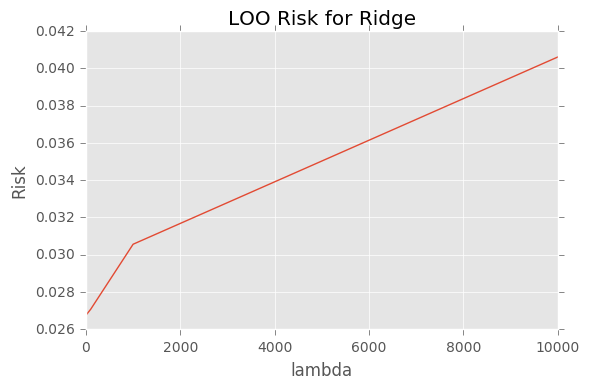

In [103]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
#plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.tight_layout()
plt.savefig("Ridge_after_DT.png")
plt.show()

In [104]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(10.0, 0.026769008101534777)

In [105]:
import xgboost